# Imports

In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from lib.util.env import getbase_dir
from encrypt import encrypt_data_in_memory
from lib.mybloom.bloomutil import jaccard_coefficient
from splitting_bf.evaluation import split_bf #change method
from splitting_bf.evaluation import simulated_sbf_protocol


import matplotlib.ticker as ticker

#isTrueMatch(gold_standard_dblp_acm,'journals/sigmod/Dogac02',507340)

# Metodos

## Metodos de simulacao

In [2]:
def split_ds(df,n):
    retorno = []
    for row in df:
        retorno.append([row[0],row[1],split_bf(row[1],n),n])
    return pd.DataFrame(retorno, columns = ['id' , 'bf', 'sbf' , 'n_sbf'])


def calculate_sbf_similarity(dfa,dfb,split_pos=0):
    """
    O split_sim e apenas o do split
    o sbf_sim e de tudo

    :param dfa:
    :param dfb:
    :param split_pos:
    :return:
    """
    result = []
    for indexa, rowa in dfa.iterrows():
        for indexb, rowb in dfb.iterrows():
            full_bf_sim = jaccard_coefficient(rowa[1],rowb[1])
            # print(rowa[2])
            split_sim = jaccard_coefficient(rowa[2][split_pos],rowb[2][split_pos])

            soma = 0
            for i in range(0,len(rowa[2])):
                soma += jaccard_coefficient(rowa[2][i], rowb[2][i])

            result.append({'id_a': rowa[0], 'id_b': rowb[0], 'full_bf': full_bf_sim, 'split_sim': split_sim, 'sbf_sim': soma/len(rowa[2]), 'splits': len(rowa[2])})

    return pd.DataFrame(result)


def private_calculate_precision_recall(zdf,technique):
    clean_r = []
    for index, row in zdf.iterrows():
        # if count % 100 == 0:
        #     print(count)
        # count += 1

        # id_max = zdf[(zdf['id_a'] == row['id_a']) & (zdf['id_b'] == row['id_b'])]['sbf_sim'].idxmax()
        id_max_a = zdf[(zdf['id_a'] == row['id_a'])][technique].idxmax()
        id_max_b = zdf[(zdf['id_b'] == row['id_b'])][technique].idxmax()

        if (id_max_a == id_max_b) and (id_max_a == index):
            # print(row)
            rp = {'id_a': row['id_a'], 'id_b': row['id_b'], 'sbf_sim': row['sbf_sim'], 'bf_sim': row['bf_sim'],
                  'sbf_stat': row['sbf_stat'],'bf_stat': row['bf_stat']}
            clean_r.append(rp)

    return pd.DataFrame(clean_r)


    zdf = x_final
    gs = gs_dict
    for a in zdf.alfa.unique():
        max_p_bf = -1
        max_r_bf = -1
        for e in zdf.beta_error.unique():
            for s in zdf.sbf_splits.unique():
                # quociente full bf
                clean_bf = zdf[(zdf.alfa == a) & (zdf.beta_error == e) & (zdf.sbf_splits == s)]
                qp_bf = len(clean_bf[clean_bf.bf_stat == 'FM']) + len(clean_bf[clean_bf.bf_stat == 'TM'])
                if qp_bf != 0:
                    p_bf = len(clean_bf[clean_bf.bf_stat == 'TM']) / qp_bf
                else:
                    print('aqui')
                    p_bf = 0

                r_bf = len(clean_bf[clean_bf.bf_stat == 'TM']) / len(gs)
                max_p_bf = max(max_p_bf,p_bf)
                max_r_bf = max(max_r_bf,r_bf)

## Metodos de plotagem

In [3]:
def plot_line_metric(dfm, title, ds='dblp_acm', dir='sbf_03'):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(data=pf, x='threshold_alfa', y='vals', hue='bf_type',
                 linewidth=2.5, dashes=[(0, 0), (2, 2)])
    # sns.barplot(data=pf, x='threshold_alfa', y='vals', hue='cols',
    #             linewidth=2.5)
    # palette = "tab10"
    ax.set_title(title)
    ax.set_ylabel("")
    ax.grid('on')
    plt.tight_layout()
    plt.show()
    fig.savefig(file)
    file = getbase_dir(['results', dir, ds + title + '.png'])


def plot_metric(df,metric='f1'):
    """

    :param df:
    :param metric: recall, precision and f1 (default)
    :return:
    """

    # global fig, ax, y, x
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=df, x='alfa', y=metric+'_sbf',
                capsize=.2, color='gray')
    # ax2 = ax.twinx()
    y = []
    for x in df.alfa.unique():
        y.append(df[df.alfa == x][metric+'_bf_full'].max())
    ax.plot(ax.get_xticks(), y, color='red',
            linestyle='--', linewidth=3, label='full_bf')
    ax.grid('on')
    # ax2.grid(False)
    # plt.tight_layout()
    plt.show()
    plt.close()
    plt.clf()

def plot_all_metrics(df,ds='dblp-acm',fsize=(12, 5)):
    """

    :param df:
    :param metric: recall, precision and f1 (default)
    :return:
    """

    # global fig, ax, y, x
    fig, axs = plt.subplots(figsize=fsize, ncols=3)
    metrics = ['f1','precision', 'recall']
    for i in range(0, len(axs)):
        ax = axs[i]
        metric = metrics[i]
        sns.barplot(data=df, x='alfa', y=metrics[i] + '_sbf',
                    capsize=.1, color='skyblue', alpha=0.8 ,
                    ax=ax)
        # sns.barplot(data=df, x='alfa', y=metrics[i] + '_sbf',
        #             capsize=.2, ax=ax)

        ax.set_title(metric)

        y = []
        for x in df.alfa.unique():
            y.append(df[df.alfa == x][metrics[i] + '_bf_full'].mean())

        ax.plot(ax.get_xticks(), y, color='red',
                linestyle='--', linewidth=2, label='full_bf')
        ax.grid('on')
        ax.set_ylabel("")
        ax.set_xlabel(r'$\alpha$')

    plt.tight_layout()
    plt.show()
    plt.close()
    plt.clf()
#     file = getbase_dir(['results', 'abel_01']) + 'plot_all_metrics_considering_alfas_' + ds + '.png'
    file = getbase_dir(['results', 'vldb']) + 'plot_all_metrics_considering_alfas_' + ds + '.png'
    file = getbase_dir(['results', 'vldb']) + 'plot_all_metrics_considering_alfas_' + ds + '.pdf'
    fig.savefig(file, dpi=300)

# Processamento

## variaveis de ambiente

In [4]:
gold_standard_dblp_acm = pd.read_csv(getbase_dir(['Datasets', 'leipzig_dblp_acm']) + 'DBLP-ACM_perfectMapping.csv',
                                         sep=',')
gs_dict = {}
for indexa, row in gold_standard_dblp_acm.iterrows():
    gs_dict[str(row[0])+str(row[1])] = True

del gold_standard_dblp_acm

## Simulação

### Calcular similaridade

##### Carregar variaveis

In [ ]:
acm = pd.read_csv(getbase_dir(['Datasets', 'leipzig_dblp_acm']) + 'ACM.csv', sep=',')
dblp = pd.read_csv(getbase_dir(['Datasets', 'leipzig_dblp_acm']) + 'DBLP2.csv', sep=',', encoding='latin')

eacm = encrypt_data_in_memory(acm, [1, 2, 3, 4], 1024)
edblp = encrypt_data_in_memory(dblp, [1, 2, 3, 4], 1024)

### Computar similaridades

In [ ]:
    splits_lenght = [3 , 4 , 5 , 6 , 7 , 8]
    similarity = []

    for s in splits_lenght:
        print(s)
        #df_acm = split_ds(eacm[0:10], s)
        #df_dblp = split_ds(edblp[0:10], s)
        df_acm = split_ds(eacm, s)
        df_dblp = split_ds(edblp, s)
        import time
        start_time = time.time()
        z = calculate_sbf_similarity(df_dblp,df_acm)
        print("\t %s seconds" % (time.time() - start_time))
        if len(similarity) == 0:
            similarity = z
        else:
            similarity = pd.concat([similarity, z])

    del df_acm
    del df_dblp

    similarity.to_csv(getbase_dir(['results', 'abel_01']) + 'dblp_acm_sim.csv')

### Simular protocolo

#### Caregar similaridade

In [4]:
similarity = pd.read_csv(getbase_dir(['results', 'abel_01']) + 'dblp_acm_sim.csv')
# z = similarity[(similarity.id_a=='conf/vldb/PoosalaI96') & (similarity.id_b==304587)]
print(similarity.memory_usage(index=True).sum()/1024/1024)

1921.3882446289062


ajuste nos dados se necessario

In [14]:
# len(similarity)
    # len(similarity[similarity.splits.isin([3,5,8])])
len(similarity)
s = similarity[similarity['splits'].isin([8, 16,32,64,128])]
len(s)
del similarity
similarity = s
del s
#del indexa
#del row

In [7]:
del acm
del dblp
del eacm
del edblp

NameError: name 'acm' is not defined

#### Simulação do protocolo

In [6]:
chunks = np.array_split(similarity, 12)
del similarity

In [16]:
# alfas_t = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#v = 'alfa1'
v = 'alfa5e'
alfas_t = [.5]
x_final = []
errors_a5 = [.001,.01,.025,.5,.15,.2,.25,.3,.37]
# from multiprocessing.pool import ThreadPool
# pool = ThreadPool(processes=8)
pool = mp.Pool(processes=4)

for c in range(0,len(chunks)):
    sim_chunk = chunks.pop(0)
    
    print("=========== chunk: " + str(c))
    
    total = 0
    for k in range(0,len(chunks)):
        total += sim_chunk.memory_usage(index=True).sum()/1024/1024
    print(total)
    
    for alfa in alfas_t:
        print("=== " + str(alfa))
        # x.to_csv('x.csv',index=False)
        # x = pd.read_csv('x.csv')

        # stand alone
        # x = simulated_sbf_protocol(similarity, gs_dict, alfa , error= 0.1)
        # para utilizar  a simulaçao

        print("\t Poll criado")

        # results = [pool.imap(simulated_sbf_protocol,
        results = [pool.apply_async(simulated_sbf_protocol,
                                    args=(sim_chunk, gs_dict, alfa),
                                    # args=(similarity, gs_dict, alfa),
#                                     kwds={'error': e}) for e in np.arange(0.01, .2, 0.04)
                                    kwds={'error': e}) for e in errors_a5
                                    # kwds={'error': e}) for e in np.arange(0.01, .4, 0.9)
                                    #kwds={'error': e}) for e in np.arange(0.01, .4, 0.07)
                   ]

        output = [p.get() for p in results]

        x = output[0]
        for pdf in output[1:]:
            x = x.append(pdf, ignore_index=True)

        print("\t Resultados capturados")
        # salva os resultados intermediarops
        x.to_csv(
            getbase_dir(['results', 'abel_01']) + 'intermediate_dblp_acm_'+v+'_chunk' + str(c) + '_' + str(alfa) + '.csv')
        print("\t Resultados salvos")
    del sim_chunk
    
pool.close()
#         if len(x_final) == 0:
#             x_final = x
#         else:
#             x_final = pd.concat([x_final, x])

#del chunks, output
#del pool
#del pd
#del results
#### fora do for
#x_final.to_csv(getbase_dir(['results', 'abel_01']) + 'dblp_acm_x_final_'+v+'.csv')

=========== chunk: 0
1677.4026489257812
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 1
1524.9114990234375
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 2
1372.4203491210938
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 3
1219.92919921875
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 4
1067.4380493164062
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 5
914.9468994140625
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 6
762.4557495117188
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 7
609.96435546875
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 8
457.4732666015625
=== 0.5
	 Poll criado
	 Resultados capturados
	 Resultados salvos
=========== chunk: 9
304.982177734375
=== 0.5
	 Poll c

AttributeError: 'list' object has no attribute 'to_csv'

In [18]:
# recuperar pelos intermediarios
x_final = []
for alfa in alfas_t:
    for c in range(0,12): 
        x = pd.read_csv(getbase_dir(['results', 'abel_01']) + 'intermediate_dblp_acm_'+v+'_chunk' + str(c) + '_' + str(alfa) + '.csv')
        if len(x_final) == 0:
            x_final = x
        else:
            x_final = pd.concat([x_final, x])

x_final.to_csv(getbase_dir(['results', 'abel_01']) + 'dblp_acm_x_final_'+v+'.csv')

#### Salvandos os resultados

In [5]:
def calculate_precision_recall(zdf, gs, ds_name , full_bf_len=1024):

    # zdf = fdf[fdf.abel_1st_s == True]
    count = 0

    saida = []
    for a in zdf.alfa.unique():
        max_p_bf = -1
        max_r_bf = -1
        for e in zdf.beta_error.unique():
            for s in zdf.sbf_splits.unique():
                # quociente full bf'
                clean_bf = zdf[(zdf.alfa == a) & (zdf.beta_error == e) & (zdf.sbf_splits == s)]
                
                TP = len(clean_bf[clean_bf.bf_stat == 'TM'])
                #FALSE POSITIVE
                FP = len(clean_bf[clean_bf.bf_stat == 'FM'])
                #FALSE NEGATIVE
                FN = len(gs) - TP
                
                qp_spf = TP + FP
                if qp_spf != 0:
                    p_bf = TP / qp_spf
                else:
                    p_sbf = 0
                
                r_bf = TP / (TP + FN)
                
                max_p_bf = max(max_p_bf, p_bf)
                max_r_bf = max(max_r_bf, r_bf)
#                 print(max_r_bf)
        
        del clean_bf
        del p_bf
        del r_bf


        for e in zdf.beta_error.unique():
            for s in zdf.sbf_splits.unique(): 
                
                #Colocar true no 1st_la
                clean_sbf = zdf[(zdf.abel_1st_s == True ) & (zdf.alfa == a) & (zdf.beta_error == e) & (zdf.sbf_splits == s)]
                
                #TRUE POSITIVE
                TP = len(clean_sbf[clean_sbf.sbf_stat == 'TM'])
                #FALSE POSITIVE
                FP = len(clean_sbf[clean_sbf.sbf_stat == 'FM'])
                #FALSE NEGATIVE
                FN = len(gs) - TP               
                
                # cociente precision
                qp_spf = TP + FP
                if qp_spf != 0:
                    p_sbf = TP / qp_spf
                else:
                    p_sbf = 0

                r_sbf = TP / (TP + FN)

                saida.append([ds_name, s, full_bf_len, a, e, p_sbf, r_sbf, max_p_bf, max_r_bf])

    return pd.DataFrame(saida, columns = ['ds_name', 'sbf_splits' , 'bf_len' ,
                                          'alfa' , 'beta_error', 'precision_sbf' ,
                                          'recall_sbf' , 'precision_bf_full' , 'recall_bf_full' ])



salvando os resultados finais

In [24]:
final_result = calculate_precision_recall(x_final, gs_dict, 'dblp_acm')
final_result['f1_bf_full'] = 2 * ((final_result['precision_bf_full'] * final_result['recall_bf_full']) / (final_result['precision_bf_full'] + final_result['recall_bf_full']))
final_result['f1_sbf'] = 2 * ((final_result['precision_sbf'] * final_result['recall_sbf']) / (final_result['precision_sbf'] + final_result['recall_sbf']))
final_result['ls'] = (final_result.bf_len / final_result.sbf_splits) / final_result.bf_len
final_result.to_csv(getbase_dir(['results', 'abel_01']) + 'dblp_acm_final_result_'+v+'.csv')

## Graficos

### carregandos os dados

In [6]:
v = 'b1' #old computado errado
# v = 'alfa5'
# v = 'alfa5e'

rf = 'dblp_acm_final_result_'+v+'.csv'
xf = 'dblp_acm_x_final_'+v+'.csv'

x_final = pd.read_csv(getbase_dir(['results', 'abel_01']) + xf)
final_result = pd.read_csv(getbase_dir(['results', 'abel_01']) + rf)


In [7]:
final_result = calculate_precision_recall(x_final,gs_dict,'dblp-acm')
final_result['f1_bf_full'] = 2 * ((final_result['precision_bf_full'] * final_result['recall_bf_full']) / (final_result['precision_bf_full'] + final_result['recall_bf_full']))
final_result['f1_sbf'] = 2 * ((final_result['precision_sbf'] * final_result['recall_sbf']) / (final_result['precision_sbf'] + final_result['recall_sbf']))
final_result['ls'] = (final_result.bf_len / final_result.sbf_splits) / final_result.bf_len
#final_result.to_csv(getbase_dir(['results', 'abel_01']) + 'dblp_acm_final_result_alfa5.csv')

ajustes nos dados 

In [8]:
final_result = final_result[final_result.sbf_splits != max(final_result.sbf_splits.unique())]

### Figura 1

Mericas individualizadas

In [ ]:
plot_metric(final_result, metric='f1')
plot_metric(final_result,metric='precision')
plot_metric(final_result, metric='recall')

Todas as metricas

D:\Programas\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Programas\Anaconda3\lib\site-

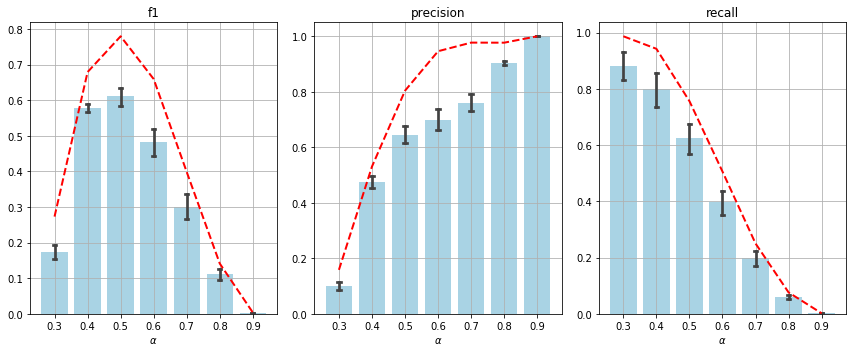

<Figure size 432x288 with 0 Axes>

In [8]:
plot_all_metrics(final_result)

In [9]:
def plot_all_metrics_vertical(df,ds='dblp-acm',fsize=(8, 12)):
    """

    :param df:
    :param metric: recall, precision and f1 (default)
    :return:
    """

    fig, axs = plt.subplots(3,1,figsize=fsize)
    metrics = ['f1','precision', 'recall']
    for i in range(0, len(axs)):
        ax = axs[i]
        metric = metrics[i]
        sns.barplot(data=df, x='alfa', y=metrics[i] + '_sbf',
                    capsize=.1, color='skyblue', alpha=0.8 ,
                    ax=ax)
        # sns.barplot(data=df, x='alfa', y=metrics[i] + '_sbf',
        #             capsize=.2, ax=ax)

        ax.set_title(metric)

        y = []
        for x in df.alfa.unique():
            y.append(df[df.alfa == x][metrics[i] + '_bf_full'].mean())

        ax.plot(ax.get_xticks(), y, color='red',
                linestyle='--', linewidth=2, label='full_bf')
        ax.grid('on')
        ax.set_ylabel("")
        ax.set_xlabel(r'$\alpha$')

    plt.tight_layout()
    plt.show()
    plt.close()
    plt.clf()
#     file = getbase_dir(['results', 'abel_01']) + 'plot_all_metrics_considering_alfas_' + ds + '.png'
    file = getbase_dir(['results', 'vldb']) + 'plot_all_metrics_considering_alfas_' + ds + '.png'
    file = getbase_dir(['results', 'vldb']) + 'plot_all_metrics_considering_alfas_' + ds + '.pdf'
    fig.savefig(file, dpi=300)

D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


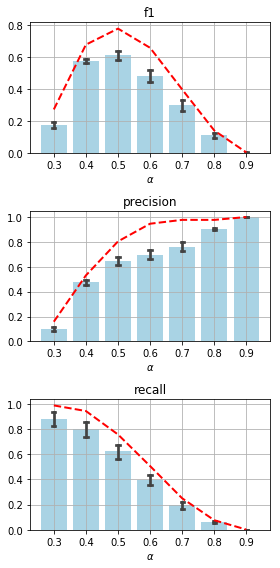

<Figure size 432x288 with 0 Axes>

In [15]:
plot_all_metrics_vertical(final_result,fsize=(4,8))

teste estatiscos da figura 1

In [16]:
from scipy.stats import wilcoxon , ttest_ind
#  null hypothesis of identical average scores. (< 0.05)
for metric in ['f1','precision','recall']:
    y_bf = []
    y_sbf = []
    # metric = 'f1'
    for x in final_result.alfa.unique():
        y_bf.append(final_result[final_result.alfa == x][metric + '_bf_full'].mean())
        y_sbf.append(final_result[final_result.alfa == x][metric + '_sbf'].median())
    print(metric)
        # print(wilcoxon(final_result[metric + '_bf_full'], final_result[metric + '_bf_full']))
    print(ttest_ind(y_bf,y_sbf))

f1
Ttest_indResult(statistic=0.490584860448264, pvalue=0.6325680992243987)
precision
Ttest_indResult(statistic=0.8769431333831554, pvalue=0.3977339639211033)
recall
Ttest_indResult(statistic=0.09090276712234692, pvalue=0.9290696164534866)


### Figura 2

#### Metodo da plotagem

In [9]:
def plot_quality_considering_error(df,limiar,metric='f1'):

    ldf = df[df.alfa == limiar].round(3)
    ldf.ls = ldf.ls.astype(str) + '%'
    # ldf['ls'] = (final_result.bf_len / final_result.sbf_splits) / final_result.bf_len
    # ldf.sbf_splits = ldf.sbf_splits.astype(str)
    fig, ax = plt.subplots(figsize=(8, 5))
    # palette = dict(zip(ldf.sbf_splits.unique(), sns.color_palette()))
    # palette.update({"Total": "k"})
    sns.lineplot(data=ldf, x='beta_error', y=metric+'_sbf', hue="ls")
    y = []
    for x in ax.get_xticks():
        y.append(df[metric+'_bf_full'].max())
    ax.plot(ax.get_xticks(), y, color='red',
            linestyle='--', linewidth=3, label='Sine')
    # sns.lineplot(data=ldf, x='beta_error', y='f1_sbf', hue="sbf_splits", palette=palette)
    ax.grid(True)
    plt.show()
    plt.close()
    plt.clf()

def plot_all_quality_considering_error(df,limiar,ds='dblp-acm',pontos=[],fs=(12, 5.5)):
    """

    :param df:
    :param limiar:
    :param ds:
    :return:
    """

    ldf = df[df.alfa == limiar]

    ldf['z'] = df.bf_len / df.sbf_splits
    ldf['split_length'] = ldf.ls.round(3).astype(str) + '% '
    ldf.split_length = ldf.split_length + '(' +ldf.z.astype(str) + ' bits)'
    ldf['beta'] = limiar - ldf.beta_error
    # min_x = ldf.beta.min()
    # max_x = ldf.beta.max()
    min_x = ldf.beta_error.min()
    max_x = ldf.beta_error.max()

    fig, axs = plt.subplots(figsize=fs, ncols=3)
    metrics = ['precision', 'recall','f1']
    for i in range(0, len(axs)):
        metric = metrics[i]

        ax = axs[i]
        ax.set_xlim(min_x,max_x)
        # ax.set_xlim(max_x,min_x)
        ax.set_title(r"" +metric + " $\\alpha$ ="+ str(limiar) )

        g = sns.lineplot(data=ldf, x='beta_error', y=metric + '_sbf',
                         hue="split_length", ax=ax , linewidth=2)
        # g = sns.lineplot(data=ldf, x='beta', y=metric+'_sbf',
        #                 hue="split_length", ax=ax)

        ax.set_ylabel("")
        ax.set_xlabel("error \n $\\beta = \\alpha - error$")

        y = []
        for x in ax.get_xticks():
            y.append(ldf[metric+'_bf_full'].mean())

        ax.plot(ax.get_xticks(), y, color='red',
                linestyle='--', linewidth=2, label='full_bf')

        #### errros
        if len(pontos) != 0:
            if metric != 'f1-':
                cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
                cc = 0
                for vx in pontos.round(2).y:
                    # ax.axvline(x=vx, linewidth=2, c=c.colors[cc], alpha=0.8)
                    ax.axvline(x=vx, linewidth=10, c=cores[cc], alpha=0.2)
                    cc+=1
            # ax.scatter(pontos.x, pontos.y ,c=pontos.x, #s=scale, label=color,
            #         alpha=0.8, edgecolors='none')

            # ax.axhline(pontos.y, linewidth=2, c=pontos.x, alpha=0.8)


        ax.grid(True)
        if i == 1:
            g.legend(loc='lower center', bbox_to_anchor= (0.5, -.5) ,
                     borderaxespad=0, frameon=False,
                     fontsize = 'medium', ncol=3 )
        else:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
            ax.get_legend().remove()
            # fontsize: int or float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    plt.tight_layout()
    plt.show()
    plt.close()
    plt.clf()
    if len(pontos) == 0:
        file = getbase_dir(['results', 'vldb']) + 'plot_all_quality_considering_error_'+ds+'_alfa_'+str(limiar)+'.png'
    else:
        file = getbase_dir(['results', 'vldb']) + 'plot_all_quality_considering_error_' +ds+ '_alfa_' + str(limiar) + '_width_region.png'
    
    fig.savefig(file,dpi=300)
    file = getbase_dir(['results', 'vldb']) + 'plot_all_quality_considering_error_' +ds+ '_alfa_' + str(limiar) + '_width_region.pdf'
    fig.savefig(file)
    
    
# plot_all_quality_considering_error(final_result[final_result.beta_error <= .49], .5 ,pontos=pontos)

#### Plotagem

Definindo as regiões beta

In [11]:
a = -0.042876301194393125
b = 3.2574724870013103

fe1 = lambda x, a, b: a * np.log(b * x)
mi = fe1(.99999,a,b)
ma = fe1(.00001,a,b)
#fe1 = lambda x: -np.log(x)
#mi = fe1(.9999999999999)
#ma = fe1(.0000000000001)

normalize = lambda x,min,max:  (x - min) / (max - min)

pontos = []
for i in final_result.ls.unique():
    # print("{} & {} & \\\\".format(i,fe1(i,a,b)))
    #n = normalize(fe1(i), mi, ma)
    x = fe1(i,a,b)
    n = normalize(x, mi, ma)
    
    pontos.append([i,n,x])
    #print("{0:.3f} & {1:.2f} \\\\".format(i, n))

pontos = pd.DataFrame(pontos,columns=['x','y','z'])
pontos

,x,y,z
0,0.125000,0.180617,0.038524
1,0.062500,0.240823,0.068244
2,0.031250,0.301029,0.097963
3,0.015625,0.361235,0.127683


#### Resultado

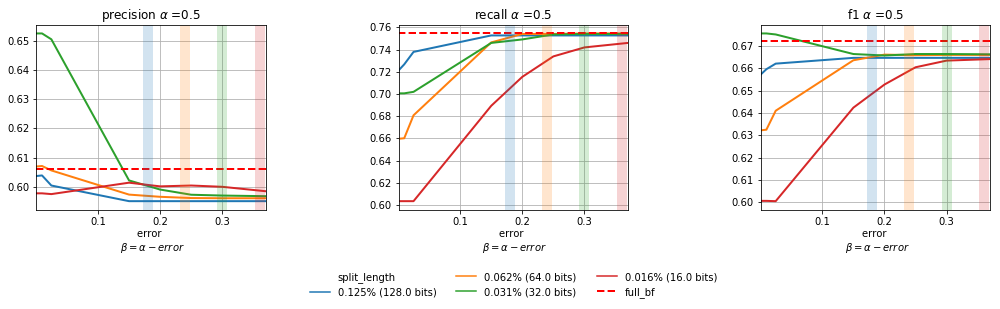

<Figure size 432x288 with 0 Axes>

In [58]:
#plot_all_quality_considering_error(final_result, .5 ,pontos=pontos[:-1])
#ldf = final_result[final_result.alfa==.5]
#plot_all_quality_considering_error(ldf, .5 ,pontos=pontos)
plot_all_quality_considering_error(final_result[final_result.beta_error <= .49], .5 ,pontos=pontos ,fs=(14,5))

plota o restante dos graficos

In [ ]:
plot_all_quality_considering_error(final_result,.4)
plot_all_quality_considering_error(final_result, .5)
plot_all_quality_considering_error(final_result,.6)
plot_all_quality_considering_error(final_result,.7)
plot_all_quality_considering_error(final_result,.8)
plot_all_quality_considering_error(final_result,.9)

In [18]:

#df['beta'] = limiar - df.beta_error
#x = df[df.abel_1st_s == True].round(3).beta.astype(str)

In [12]:
limiar = .5
s = 16
all_df =  x_final[(x_final.alfa == limiar) & (x_final.beta_error <= .49)]
#               &(x_final.sbf_splits == s)
#              & (x_final.beta_error <= .49)]

x = []
y = []
h = []
for s in all_df.sbf_splits.unique()[:-1]:
    
    df = all_df[all_df.sbf_splits == s]
    
    for b in df.beta_error.unique():
        x.append(b)
        ltotal = len(df[df.beta_error == b])
        yl = len(df[(df.beta_error == b) & (df.abel_1st_s == True)])
        y.append(yl/ltotal)
        h.append(str(s))
    del yl
    del ltotal

In [13]:
pdf = pd.DataFrame({'x':x,'y':y,'cor':h})
# pdf['cor'] = pdf.x.astype(str)

In [14]:
# pdf.cor.unique()
pdf[pdf.cor=='128']
#pdf[pdf.x == 0.37]
# pdf.x.unique()

,x,y,cor


D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


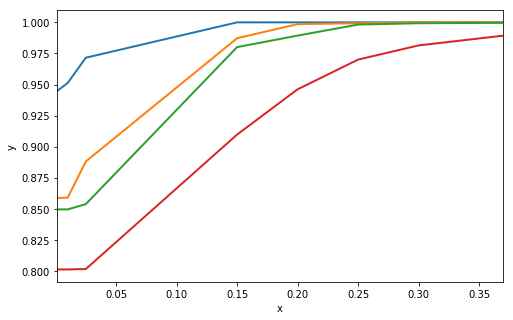

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

# sns.lineplot(x=x,y=y,data=df,ax=ax)
for i in pdf.cor.unique():
    sns.lineplot(x="x",y="y",estimator=None, lw=1 , linewidth=2 ,
                 data=pdf[pdf.cor==i],ax=ax)
    ax.set_xlim(min(pdf.x),max(pdf.x))


D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
D:\Programas\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2448: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


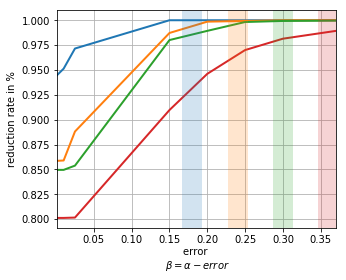

<Figure size 432x288 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))

# sns.lineplot(x=x,y=y,data=df,ax=ax)
for i in pdf.cor.unique():
    sns.lineplot(x="x",y="y",estimator=None, lw=1 , linewidth=2 ,
                 data=pdf[pdf.cor==i],ax=ax)

# sns.lineplot(x="x",y="y",
#              data=pdf,ax=ax)

#ax.set(xlim=(x))
ax.set_xlim(min(pdf.x),max(pdf.x))

#ax.axvline(x=.3, linewidth=10, c='r', alpha=0.2)
cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cc = 0
for vx in pontos.round(2).y:
    ax.axvline(x=vx, linewidth=20, c=cores[cc], alpha=0.2)
    cc+=1

# g.legend(loc='lower center', bbox_to_anchor= (0.5, -.5) ,
#                      borderaxespad=0, frameon=False,
#                      fontsize = 'medium', ncol=3 )

    
# ax.set_title(r"" +"Comparasion" + " ($\\alpha$ ="+ str(limiar)+")" )
ax.set_ylabel("reduction rate in %")
ax.set_xlabel("error \n $\\beta = \\alpha - error$")

ax.grid(True)
plt.show()
plt.close()
plt.clf()
file = getbase_dir(['results', 'vldb']) + "reduction_rate_alfa_05.png"
fig.savefig(file,dpi=300)
file = getbase_dir(['results', 'vldb']) + "reduction_rate_alfa_05.pdf"
fig.savefig(file)


redução das comparações

In [16]:
n_ds1=2617
n_ds2=2294
t = n_ds1 * n_ds2

x = df.beta_error.unique()
y = []
for b in x:
    ltotal = len(df[df.beta_error == b])
    yl = len(df[(df.beta_error == b) & (df.abel_1st_s == True)])
    y.append((yl/t)*100)
del yl
del ltotal
y


[0.0373954883550949,
 0.0373954883550949,
 0.037412145588215207,
 0.04245928722366899,
 0.04415832500194057,
 0.045274359621001306,
 0.04580739108085121,
 0.046173850209498025]

# Pre-Scratch

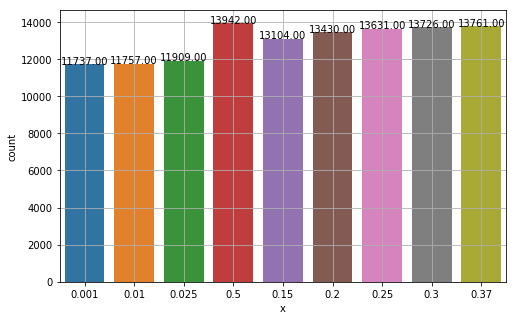

<Figure size 432x288 with 0 Axes>

In [37]:
n_ds1=2617
n_ds2=2294

t = n_ds1 * n_ds2
df['x'] = df[df.abel_1st_s == True].round(3).beta_error.astype(str)
df['y'] = 1 / t
df['y'] = 1
from matplotlib.ticker import PercentFormatter


total = len(df[df.x == '0.33'])

fig, ax = plt.subplots(figsize=(8, 5))
# g = sns.catplot(x="x", y="y", hue="y", kind="bar", data=df)
# for ax in g.axes.flat:
#     ax.yaxis.set_major_formatter(PercentFormatter(1))
# plt.show()
# g = sns.catplot(x="x", kind="count", data=df)

g = sns.countplot(x="x", data=df)  # for Seaborn version 0.7 and more
for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:1.2f}'.format(height)/total,
            ha="center")
ax.grid(True)
plt.show()
plt.close()
plt.clf()

#file = getbase_dir(['results', 'abel_01']) + 'zzz_05_alfa_' + '.png'
#fig.savefig(file, dpi=400)

# Scratch

In [ ]:
    # final_result[(final_result.sbf_splits != 128) & (final_result.sbf_splits != 64)

    n_ds1=2617
    n_ds2=2294

    t = n_ds1 * n_ds2
    df['x'] = df[df.abel_1st_s == True].round(3).beta.astype(str)
    df['y'] = 1 / t
    df['y'] = 1
    from matplotlib.ticker import PercentFormatter


    total = len(df[df.x == '0.33'])

    fig, ax = plt.subplots(figsize=(8, 5))
    # g = sns.catplot(x="x", y="y", hue="y", kind="bar", data=df)
    # for ax in g.axes.flat:
    #     ax.yaxis.set_major_formatter(PercentFormatter(1))
    # plt.show()
    # g = sns.catplot(x="x", kind="count", data=df)

    g = sns.countplot(x="x", data=df)  # for Seaborn version 0.7 and more
    for p in g.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}'.format(height / total),
                ha="center")
    ax.grid(True)
    plt.show()
    plt.close()
    plt.clf()

    file = getbase_dir(['results', 'abel_01']) + 'zzz_05_alfa_' + '.png'
    fig.savefig(file, dpi=400)



##########################################################################
### scratch
########################################################################
def exec_01(n):
    import time
    start_time = time.time()
    ids_a = [640999,190649, 615205, 375780, 375736]
    ids_b = ['journals/sigmod/Winslett03','journals/sigmod/Kim94', 'conf/sigmod/BlakeleyD00', 'conf/sigmod/NazeriBO01', 'conf/sigmod/BorkarDS01' ]
    for a in ids_a:
        for b in ids_b:
            print(isTrueMatchOriginal(gs, b, a))
    print(time.time() - start_time)


print(exec_01(1))

gs =  gold_standard_dblp_acm.copy()

gs.set_index(['idDBLP', 'ix'])

ida = 'journals/sigmod/Winslett03'
idb = 640999


d = {}
for indexa, row in gs.iterrows():
    d[str(row[0])+str(row[1])] = True

def isTrueMatch2(gs,ida,idb,base_a='idDBLP',base_b='idACM'):
    try:
        gs[str(ida)+str(idb)]
        return True
    except KeyError:
        print
        return False
    #     # gs[(gs[base_a] == ida) & (gs[base_b] == idb)]
    # if len(z) == 1:
    #     return True
    #
    # return False